In [1]:
# import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud

plt.style.use('ggplot')

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare data

Dataset: [MovieLens Small](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

In [2]:
# load data

movies = pd.read_csv('MovieLens/movies.csv')
ratings = pd.read_csv('MovieLens/Ratings.csv').drop(['timestamp'],axis=1)
tags = pd.read_csv('MovieLens/tags.csv')

## Ratings

A user is considered to like n item if they've given it a rating above their average rating across all the items they've consumed.

### Find each user's average rating

In [3]:
mean_ratings = ratings.groupby(['userId']).mean().reset_index()
mean_ratings['mean_rating'] = mean_ratings['rating']
mean_ratings.drop(['rating', 'movieId'],axis=1, inplace=True)
ratings_with_mean = pd.merge(ratings, mean_ratings, on=['userId', 'userId'])
ratings_with_mean.head(10)

,userId,movieId,rating,mean_rating
0,1,1,4.0,4.366379
1,1,3,4.0,4.366379
2,1,6,4.0,4.366379
3,1,47,5.0,4.366379
4,1,50,5.0,4.366379
5,1,70,3.0,4.366379
6,1,101,5.0,4.366379
7,1,110,4.0,4.366379
8,1,151,5.0,4.366379
9,1,157,5.0,4.366379


#### Get rid of users that have rated no items at all, as they do not help our analysis

In [4]:
ratings_with_mean = ratings_with_mean.drop(ratings_with_mean[ratings_with_mean['mean_rating'] == 0.0].index)
ratings_with_mean.head(10)

,userId,movieId,rating,mean_rating
0,1,1,4.0,4.366379
1,1,3,4.0,4.366379
2,1,6,4.0,4.366379
3,1,47,5.0,4.366379
4,1,50,5.0,4.366379
5,1,70,3.0,4.366379
6,1,101,5.0,4.366379
7,1,110,4.0,4.366379
8,1,151,5.0,4.366379
9,1,157,5.0,4.366379


#### For each user, only keep items above their average rating. These are the items considered to be liked by the user

In [5]:
ratings_with_mean = ratings_with_mean.drop(ratings_with_mean[ratings_with_mean['rating'] < ratings_with_mean['mean_rating']].index)
ratings_with_mean.head(10)

,userId,movieId,rating,mean_rating
3,1,47,5.0,4.366379
4,1,50,5.0,4.366379
6,1,101,5.0,4.366379
8,1,151,5.0,4.366379
9,1,157,5.0,4.366379
10,1,163,5.0,4.366379
11,1,216,5.0,4.366379
13,1,231,5.0,4.366379
15,1,260,5.0,4.366379
18,1,333,5.0,4.366379


#### Merge users and movies dataframes

In [6]:
movies_with_ratings = pd.merge(movies, ratings_with_mean, on=['movieId','movieId'])
movies_with_ratings.head(10)

,movieId,title,genres,userId,rating,mean_rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,3.636364
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,3.230263
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,4.209524
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,4.0,2.607397
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,21,3.5,3.260722
5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,31,5.0,3.920000
6,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,40,5.0,3.766990
7,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,43,5.0,4.552632
8,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,45,4.0,3.875940
9,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,46,5.0,4.000000


### Create crosstable showing each user and the number of times they have 'liked' each movie

In [7]:
user_vs_movie = pd.crosstab(movies_with_ratings['userId'], movies_with_ratings['movieId'])
user_vs_movie.head(10)

movieId,1,2,3,5,6,7,8,9,10,11,...,188833,189111,189333,190183,190209,191005,193571,193573,193581,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
user_vs_movie.shape

(610, 7141)

### Dimensionality reduction

In [9]:
# dimensionality reduction with Principal Component Analysis

pca = PCA(n_components=3)
pca.fit(user_vs_movie)
pca_samples = pca.transform(user_vs_movie)
user_vs_movie_3d = pd.DataFrame(pca_samples)
user_vs_movie_3d.head(10)

,0,1,2
0,1.558153,1.024391,-1.520523
1,-1.773076,-0.665379,0.559082
2,-2.160522,0.073087,0.061225
3,0.823437,2.577994,0.229407
4,-1.689158,0.476366,-0.373718
5,-0.736768,0.890371,-2.770071
6,0.918509,-0.998414,-0.244893
7,-1.600816,0.266928,-0.528654
8,-1.664580,-0.052038,0.312506
9,-0.771931,-1.497153,0.907118


In [10]:
tocluster = pd.DataFrame(user_vs_movie_3d[[0,1,2]])

<ipython-input-11-8c7564267ee2>:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


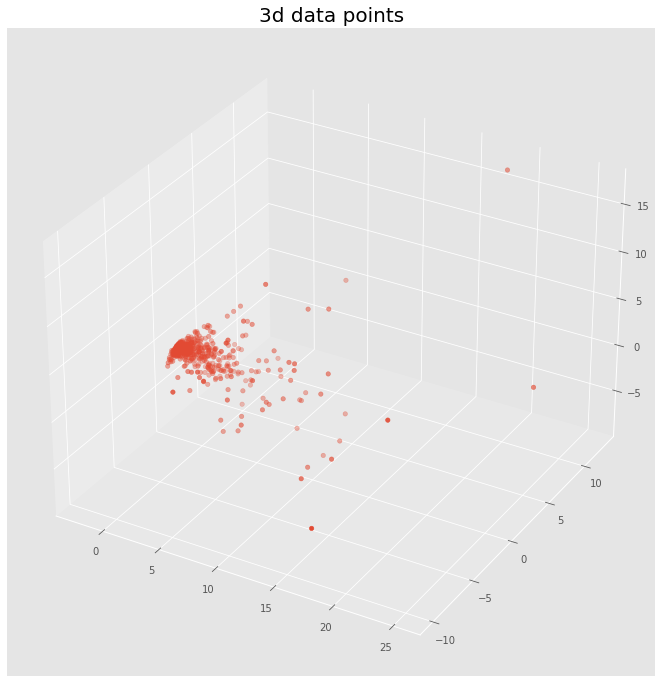

In [11]:
plt.rcParams['figure.figsize'] = (16, 9)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1])

plt.title('3d data points', fontsize=20)
plt.show()

# User Clustering

## User clustering by history of liked items (movies)

### Finding optimal number of clusters using elbow method

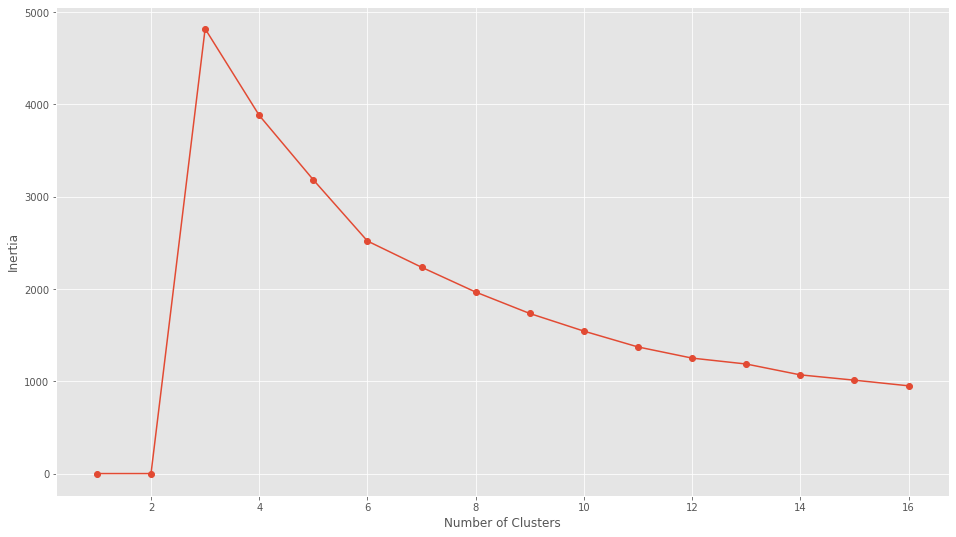

In [12]:
inertia_list = np.empty(16)

for i in range(2,16):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(tocluster)
    inertia_list[i] = kmeans.inertia_
    
plt.plot(range(1,17),inertia_list,'-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

We can see that at a cluster size of 6 is where the elbow forms

### Finding the clusters

In [13]:
clusterer = KMeans(n_clusters=6,random_state=30).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)

<ipython-input-14-fadb15d49b23>:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


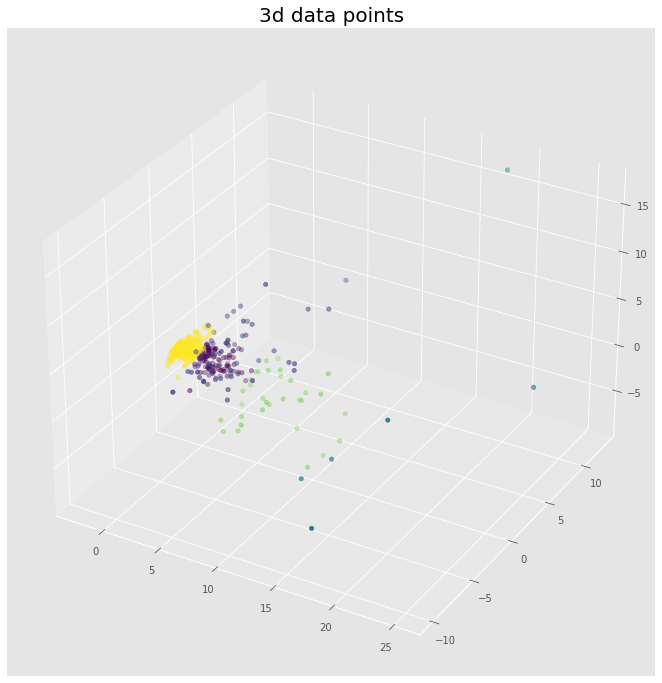

In [14]:
plt.rcParams['figure.figsize'] = (16, 9)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1], c = c_preds)

plt.title('3d data points', fontsize=20)
plt.show()

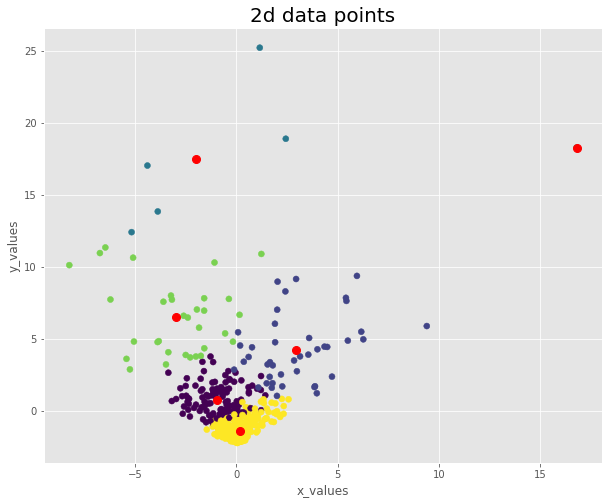

In [15]:
fig = plt.figure(figsize=(10,8))
plt.scatter(tocluster[1],tocluster[0],c = c_preds)
for ci,c in enumerate(centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('2d data points', fontsize=20)
plt.show()

## Finding the characteristics of each cluster

In [16]:
user_vs_movie['clusterId'] = c_preds
user_vs_movie.head(10)

movieId,1,2,3,5,6,7,8,9,10,11,...,189111,189333,190183,190209,191005,193571,193573,193581,193609,clusterId
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
6,0,1,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [17]:
clusters = pd.DataFrame(c_preds, columns=["clusterId"])
clusters['userId'] = clusters.index.values
movies_with_clusters = pd.merge(movies_with_ratings, clusters, on=['userId','userId'])
movies_with_clusters.head(10)

,movieId,title,genres,userId,rating,mean_rating,clusterId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,3.636364,5
1,21,Get Shorty (1995),Comedy|Crime|Thriller,5,4.0,3.636364,5
2,34,Babe (1995),Children|Drama,5,4.0,3.636364,5
3,36,Dead Man Walking (1995),Crime|Drama,5,4.0,3.636364,5
4,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5,4.0,3.636364,5
5,58,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance,5,5.0,3.636364,5
6,110,Braveheart (1995),Action|Drama|War,5,4.0,3.636364,5
7,232,Eat Drink Man Woman (Yin shi nan nu) (1994),Comedy|Drama|Romance,5,4.0,3.636364,5
8,247,Heavenly Creatures (1994),Crime|Drama,5,5.0,3.636364,5
9,261,Little Women (1994),Drama,5,4.0,3.636364,5


### Cluster 1

#### Display most popular items in this cluster and their scores

In [18]:
cluster1 = user_vs_movie[user_vs_movie['clusterId']==0].drop('clusterId',axis=1)
cluster1 = cluster1.mean(axis=0)
top = cluster1.sort_values(ascending=False)[0:15]
#top.head(15)

In [19]:
movies[movies['movieId'].isin(top.index.values)]    #movie names

,movieId,title,genres
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2226,2959,Fight Club (1999),Action|Crime|Drama|Thriller
3141,4226,Memento (2000),Mystery|Thriller
3638,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
3640,4995,"Beautiful Mind, A (2001)",Drama|Romance


#### Get and display most popular genres in this cluster

(-0.5, 399.5, 199.5, -0.5)

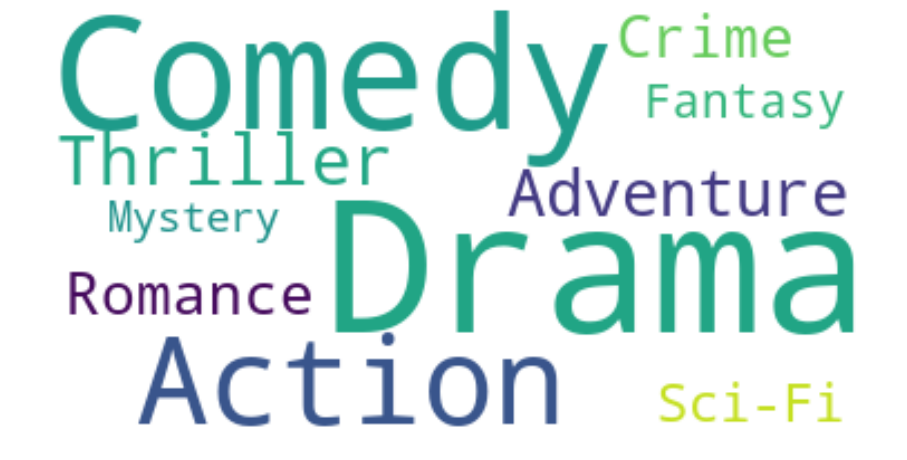

In [20]:
#get genres in this cluster
genres = movies_with_clusters[movies_with_clusters['clusterId'] == 0]['genres']    #filter rows of this cluster
genres.astype("string").array    #to string array
genres = ' '.join(genres)    #concatenate to one string
genres = genres.replace('|', ' ')    #swap | for spaces

from collections import Counter
word_freq = Counter(genres.split(' '))

#create a wordcloud of the genres
wordcloud = WordCloud(max_words=10, background_color="white").generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Cluster 2

#### Display most popular items in this cluster and their scores

In [21]:
cluster2 = user_vs_movie[user_vs_movie['clusterId']==1].drop('clusterId',axis=1)
cluster2 = cluster2.mean(axis=0)
top = cluster2.sort_values(ascending=False)[0:15]
#top.head(15)

In [22]:
movies[movies['movieId'].isin(top.index.values)]    #movie names

,movieId,title,genres
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
520,608,Fargo (1996),Comedy|Crime|Drama|Thriller
659,858,"Godfather, The (1972)",Crime|Drama
828,1089,Reservoir Dogs (1992),Crime|Mystery|Thriller
863,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
898,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi


#### Get and display most popular genres in this cluster

(-0.5, 399.5, 199.5, -0.5)

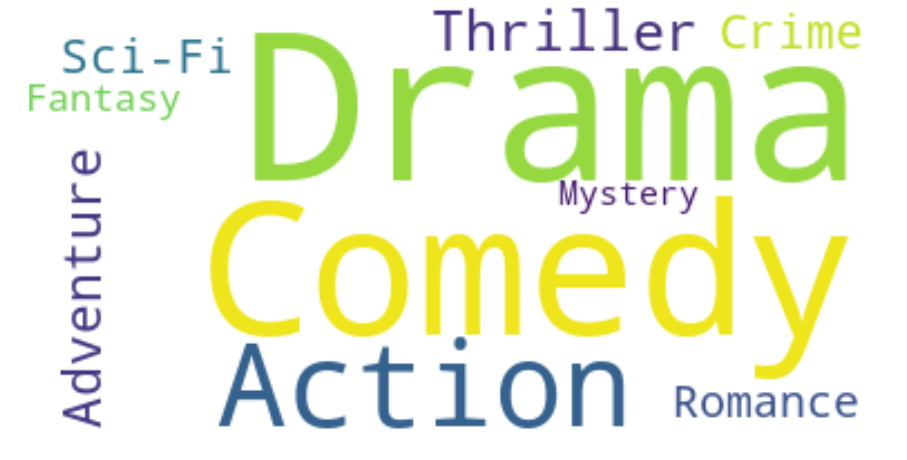

In [23]:
#get genres in this cluster
genres = movies_with_clusters[movies_with_clusters['clusterId'] == 1]['genres']    #filter rows of this cluster
genres.astype("string").array    #to string array
genres = ' '.join(genres)    #concatenate to one string
genres = genres.replace('|', ' ')    #swap | for spaces

from collections import Counter
word_freq = Counter(genres.split(' '))

#create a wordcloud of the genres
wordcloud = WordCloud(max_words=10, background_color="white").generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Cluster 3

#### Display most popular items in this cluster and their scores

In [24]:
cluster3 = user_vs_movie[user_vs_movie['clusterId']==2].drop('clusterId',axis=1)
cluster3 = cluster3.mean(axis=0)
top = cluster3.sort_values(ascending=False)[0:15]
#top.head(15)

In [25]:
movies[movies['movieId'].isin(top.index.values)]    #movie names

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
964,1265,Groundhog Day (1993),Comedy|Fantasy|Romance
965,1266,Unforgiven (1992),Drama|Western
969,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi
977,1278,Young Frankenstein (1974),Comedy|Fantasy
990,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
1067,1387,Jaws (1975),Action|Horror
1071,1391,Mars Attacks! (1996),Action|Comedy|Sci-Fi
1158,1527,"Fifth Element, The (1997)",Action|Adventure|Comedy|Sci-Fi
1267,1682,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi


#### Get and display most popular genres in this cluster

(-0.5, 399.5, 199.5, -0.5)

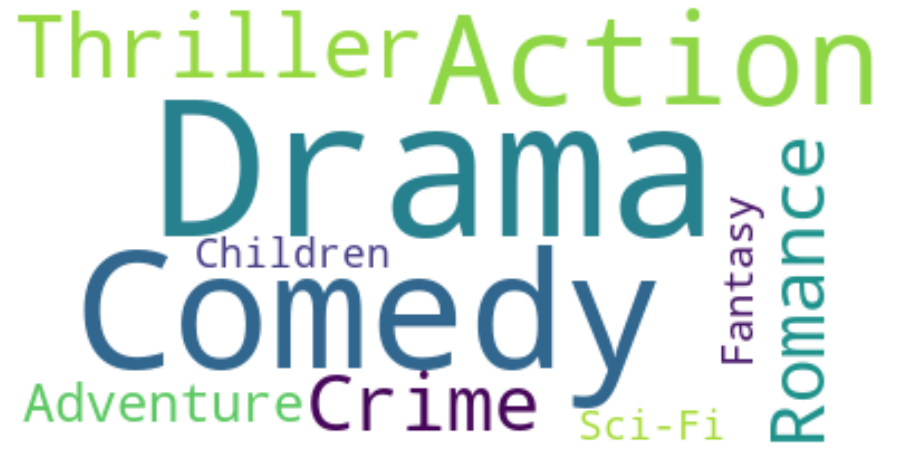

In [26]:
#get genres in this cluster
genres = movies_with_clusters[movies_with_clusters['clusterId'] == 2]['genres']    #filter rows of this cluster
genres.astype("string").array    #to string array
genres = ' '.join(genres)    #concatenate to one string
genres = genres.replace('|', ' ')    #swap | for spaces

from collections import Counter
word_freq = Counter(genres.split(' '))

#create a wordcloud of the genres
wordcloud = WordCloud(max_words=10, background_color="white").generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Cluster 4

#### Display most popular items in this cluster and their scores

In [27]:
cluster4 = user_vs_movie[user_vs_movie['clusterId']==3].drop('clusterId',axis=1)
cluster4 = cluster4.mean(axis=0)
top = cluster4.sort_values(ascending=False)[0:15]
#top.head(15)

In [28]:
movies[movies['movieId'].isin(top.index.values)]    #movie names

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2948,3952,"Contender, The (2000)",Drama|Thriller
2957,3965,"Strange Love of Martha Ivers, The (1946)",Drama|Film-Noir
2958,3966,Detour (1945),Crime|Film-Noir
2959,3967,Billy Elliot (2000),Drama
2971,3983,You Can Count on Me (2000),Drama|Romance
2977,3989,One Day in September (1999),Documentary
2980,3992,Malèna (2000),Drama|Romance|War
2982,3994,Unbreakable (2000),Drama|Sci-Fi
2983,3996,"Crouching Tiger, Hidden Dragon (Wo hu cang lon...",Action|Drama|Romance


#### Get and display most popular genres in this cluster

(-0.5, 399.5, 199.5, -0.5)

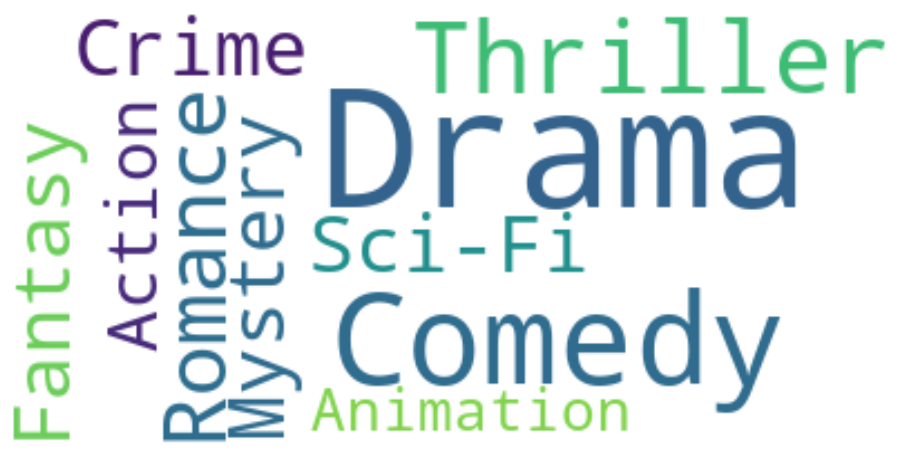

In [29]:
#get genres in this cluster
genres = movies_with_clusters[movies_with_clusters['clusterId'] == 3]['genres']    #filter rows of this cluster
genres.astype("string").array    #to string array
genres = ' '.join(genres)    #concatenate to one string
genres = genres.replace('|', ' ')    #swap | for spaces

from collections import Counter
word_freq = Counter(genres.split(' '))

#create a wordcloud of the genres
wordcloud = WordCloud(max_words=10, background_color="white").generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Cluster 5

#### Display most popular items in this cluster and their scores

In [30]:
cluster5 = user_vs_movie[user_vs_movie['clusterId']==4].drop('clusterId',axis=1)
cluster5 = cluster5.mean(axis=0)
top = cluster5.sort_values(ascending=False)[0:15]
#top.head(15)

In [31]:
movies[movies['movieId'].isin(top.index.values)]    #movie names

,movieId,title,genres
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
322,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
898,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
900,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
911,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2226,2959,Fight Club (1999),Action|Crime|Drama|Thriller
3614,4963,Ocean's Eleven (2001),Crime|Thriller
3638,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy


#### Get and display most popular genres in this cluster

(-0.5, 399.5, 199.5, -0.5)

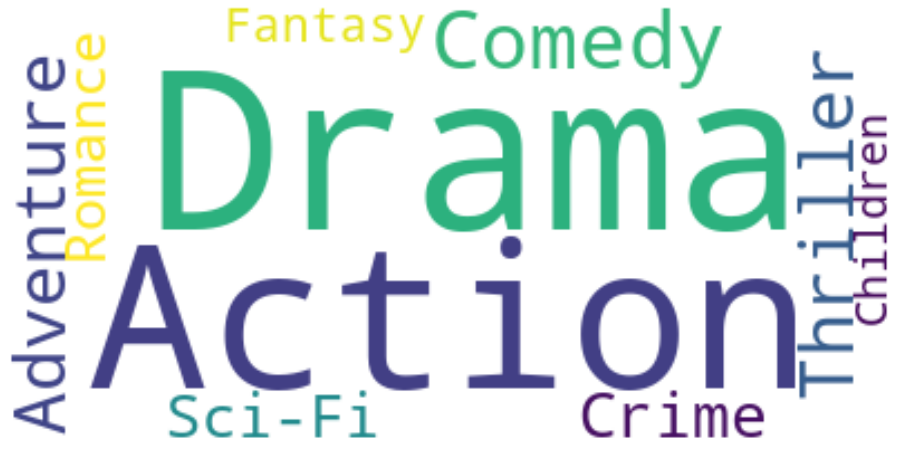

In [32]:
#get genres in this cluster
genres = movies_with_clusters[movies_with_clusters['clusterId'] == 4]['genres']    #filter rows of this cluster
genres.astype("string").array    #to string array
genres = ' '.join(genres)    #concatenate to one string
genres = genres.replace('|', ' ')    #swap | for spaces

from collections import Counter
word_freq = Counter(genres.split(' '))

#create a wordcloud of the genres
wordcloud = WordCloud(max_words=10, background_color="white").generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Cluster 6

#### Display most popular items in this cluster and their scores

In [33]:
cluster6 = user_vs_movie[user_vs_movie['clusterId']==5].drop('clusterId',axis=1)
cluster6 = cluster6.mean(axis=0)
top = cluster6.sort_values(ascending=False)[0:15]
#top.head(15)

In [34]:
movies[movies['movieId'].isin(top.index.values)]    #movie names

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
97,110,Braveheart (1995),Action|Drama|War
123,150,Apollo 13 (1995),Adventure|Drama|IMAX
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
398,457,"Fugitive, The (1993)",Thriller
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller


#### Get and display most popular genres in this cluster

(-0.5, 399.5, 199.5, -0.5)

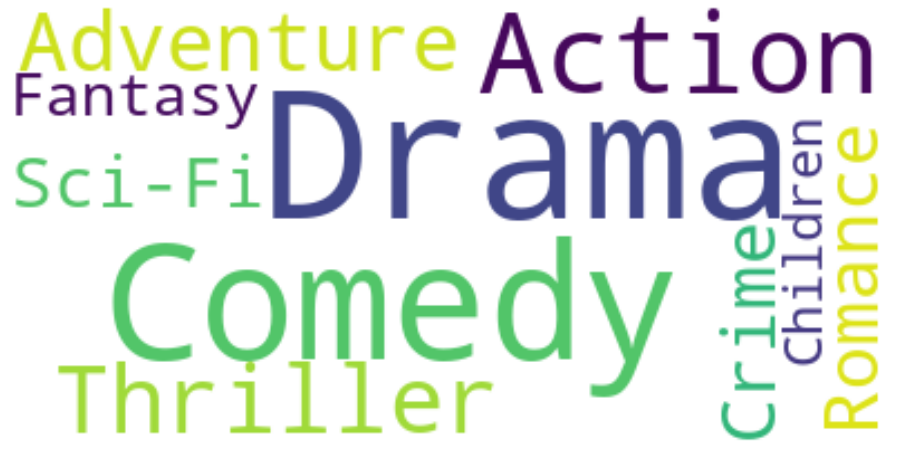

In [35]:
#get genres in this cluster
genres = movies_with_clusters[movies_with_clusters['clusterId'] == 5]['genres']    #filter rows of this cluster
genres.astype("string").array    #to string array
genres = ' '.join(genres)    #concatenate to one string
genres = genres.replace('|', ' ')    #swap | for spaces

from collections import Counter
word_freq = Counter(genres.split(' '))

#create a wordcloud of the genres
wordcloud = WordCloud(max_words=10, background_color="white").generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## User clustering by demographics (age, location, etc)

Not available in this dataset